In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import seaborn as sns
import math

##### Video Inference Strong Scaling Bar Plot


In [2]:
csv_list = []
resources = [1, 2, 4, 8]

time_taken = []
tput = []

for i in resources:
    csv_list.append(
        pd.read_csv(
            f"../video_inference/_ALL [{i}x] g5.xlarge + [{i}x] m7i.2xlarge/video_inference_s3_g5_xlarge_batch_32.csv"
        )
    )

for csv_file in csv_list:
    time_taken.append(csv_file.iloc[-1]["time_from_start"])
    tput.append(csv_file.iloc[-1]["number_of_rows_finished"] / csv_file.iloc[-1]["time_from_start"])

In [3]:
for csv_file in csv_list:
    print(csv_file.iloc[-1]["number_of_rows_finished"] / csv_file.iloc[-1]["time_from_start"])

21.35269331385775
45.784299676621806
91.33286087414686
183.3198477792353


In [4]:
time_taken

[29730.11369895935, 13866.543869495392, 6950.59799861908, 3463.040187358856]

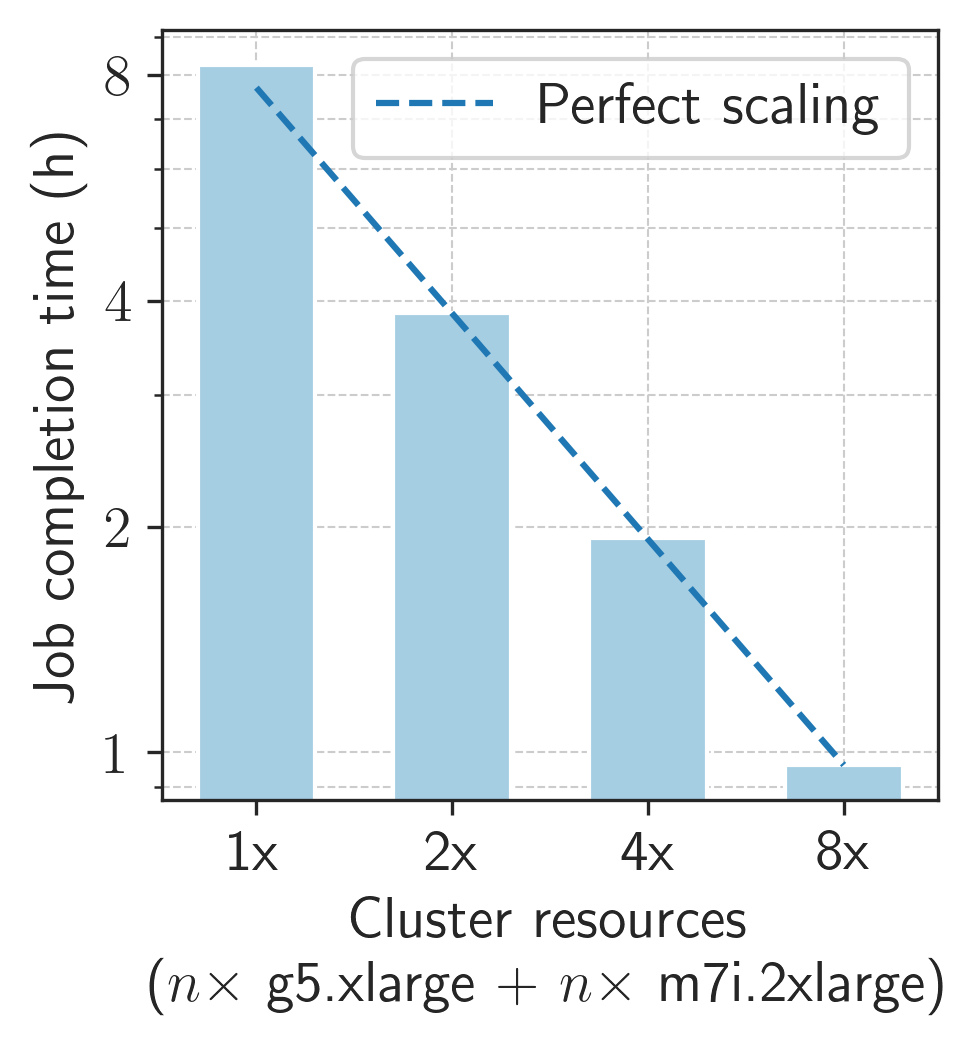

In [5]:
FIGRATIO = 4 / 4
FIGWIDTH = 3.335  # inches
FIGHEIGHT = FIGWIDTH * FIGRATIO
FIGSIZE = (FIGWIDTH, FIGHEIGHT)
BIG_SIZE = 14

resources_idx = np.arange(len(resources))
time_taken_hours = [t / 3600 for t in time_taken]

COLORS = sns.color_palette("Paired")
sns.set_style("ticks")
sns.set_palette(COLORS)

plt.rcParams.update(
    {
        "figure.figsize": FIGSIZE,
        "figure.dpi": 300,
        "text.usetex": True,
    }
)
plt.rc("font", size=BIG_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=BIG_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=BIG_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=BIG_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=BIG_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=BIG_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIG_SIZE)  # fontsize of the figure title

fig, ax = plt.subplots()

bars = ax.bar(resources_idx, time_taken_hours, color=COLORS[0], width=0.6)

perfect_scaling = [time_taken_hours[3] * r for r in resources[::-1]]
ax.plot(resources_idx, perfect_scaling, linestyle="--", color=COLORS[1], label="Perfect scaling")

ax.set_xlabel("Cluster resources \n($n\\times$ g5.xlarge + $n\\times$ m7i.2xlarge)")

ax.set_ylabel("Job completion time (h)")

ax.set_yscale("log")
y_ticks = [
    2**i
    for i in range(
        int(math.log(min(time_taken_hours), 2)), int(math.log(max(time_taken_hours), 2)) + 1
    )
]
ax.set_yticks(y_ticks)
ax.set_yticklabels([f"${int(y)}$" for y in y_ticks])
ax.set_xticks(resources_idx, [f"{x}x" for x in resources])

ax.grid(True, which="both", linestyle="--", linewidth=0.5)

ax.legend()
plt.savefig("video-scaling.pdf", bbox_inches='tight')

##### Single Node Tput Line Plot


In [14]:
BATCH_SIZE = 32
INSTANCE_TYPE = "g5_xlarge"
# data_local = pd.read_csv(f'video_inference_local_{INSTANCE_TYPE}_batch_{BATCH_SIZE}.csv')
data_s3_0_1 = pd.read_csv("../video_inference/[1x] g5.xlarge/video_inference_s3_g5_xlarge_batch_32.csv")
data_s3_1_1 = pd.read_csv("../video_inference/[1x] g5.xlarge + [1x] m7i.2xlarge/video_inference_s3_g5_xlarge_batch_32.csv")
data_s3_1_1_wf = pd.read_csv("../video_inference/_FAULT [1x] g5.xlarge + [1x] m7i.2xlarge/video_inference_s3_g5_xlarge_batch_32.csv")

In [15]:
data_s3_0_1.head()

,time_from_start,number_of_rows_finished
0,0.000000,0
1,27.537039,26
2,30.757921,52
3,34.483166,78
4,37.111850,104


In [16]:
def process(data, resample="60s"):
    data = data.copy()
    data["time_from_start"] = pd.to_timedelta(data["time_from_start"], unit="s")
    data.set_index("time_from_start", inplace=True)
    data["tput"] = data["number_of_rows_finished"].diff() / data.index.total_seconds().diff()
    data["tput"] = data["tput"].fillna(0)
    avg_tput = np.mean(data["tput"])
    # tput_resampled = data['tput'].resample(resample).bfill()
    tput_resampled = data["tput"].resample(resample).mean().bfill()
    idx = [(item.total_seconds() // 60) for item in tput_resampled.index]
    return idx, tput_resampled.values, avg_tput

In [17]:
# idx_local, values_local, avg_local = process(data_local)
# idx_s3, values_s3, avg_s3 = process(data_s3)
idx_s3_0_1, values_s3_0_1, _ = process(data_s3_0_1)
idx_s3_1_1, values_s3_1_1, _ = process(data_s3_1_1)
idx_s3_1_1_wf, values_s3_1_1_wf, _ = process(data_s3_1_1_wf)

avg_s3_0_1 = (
    data_s3_0_1.iloc[-1]["number_of_rows_finished"] / data_s3_0_1.iloc[-1]["time_from_start"]
)
avg_s3_1_1 = (
    data_s3_1_1.iloc[-1]["number_of_rows_finished"] / data_s3_1_1.iloc[-1]["time_from_start"]
)
avg_s3_1_1_wf = (
    data_s3_1_1_wf.iloc[-1]["number_of_rows_finished"] / data_s3_1_1_wf.iloc[-1]["time_from_start"]
)

avg_s3_0_1, avg_s3_1_1, avg_s3_1_1_wf

(6.188258389698372, 21.715949558226573, 18.62964358322438)

In [18]:
data_s3_0_1.iloc[-1]["time_from_start"] / 60

173.73762787977856

In [19]:
data_s3_1_1.iloc[-1]["time_from_start"] / 60

49.52964780330658

In [20]:
tput = []
with open("../video_inference/inference_tput.out", "r") as f:
    for line in f:
        tput.append(float(line))
inference_tput_mean = np.mean(tput)
inference_tput_mean

23.044661492259507

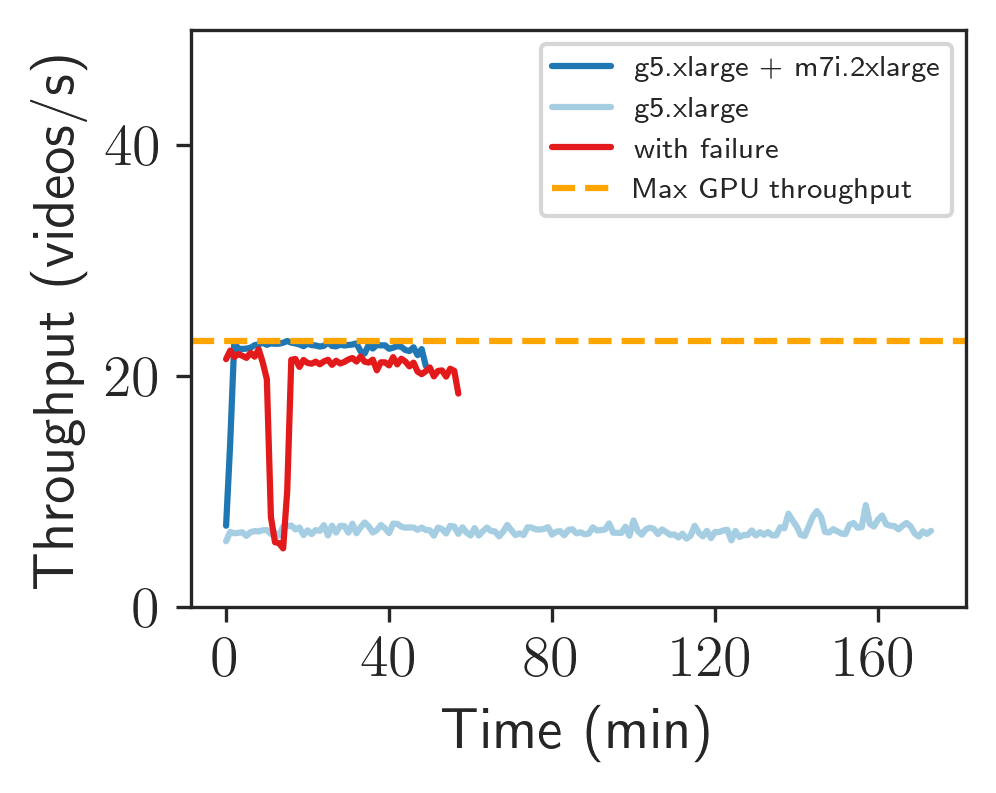

In [26]:
FIGRATIO = 3 / 4
FIGWIDTH = 3.335  # inches
FIGHEIGHT = FIGWIDTH * FIGRATIO
FIGSIZE = (FIGWIDTH, FIGHEIGHT)
BIG_SIZE = 14

COLORS = sns.color_palette("Paired")
sns.set_style("ticks")
sns.set_palette(COLORS)

plt.rcParams.update(
    {
        "figure.figsize": FIGSIZE,
        "figure.dpi": 300,
        "text.usetex": True,
    }
)
plt.rc("font", size=BIG_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=BIG_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=BIG_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=BIG_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=BIG_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=BIG_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIG_SIZE)  # fontsize of the figure title

fig, ax = plt.subplots()

ax.plot(idx_s3_1_1, values_s3_1_1, label="g5.xlarge + m7i.2xlarge", color=COLORS[1])
ax.plot(idx_s3_0_1, values_s3_0_1, label="g5.xlarge", color=COLORS[0])
ax.plot(idx_s3_1_1_wf, values_s3_1_1_wf, label="with failure", color=COLORS[5])

ax.axhline(
    y=inference_tput_mean, color="orange", linestyle="--", label="Max GPU throughput"
)

plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(nbins=6))

plt.xlabel("Time (min)")
plt.ylabel("Throughput (videos/s)")
plt.ylim(0, 50)
plt.legend(fontsize=7)
plt.savefig("video-tput.pdf", bbox_inches='tight')

##### Fault Tolerance


In [15]:
data_s3_1_1_wf = pd.read_csv("../video_inference/_FAULT [1x] g5.xlarge + [1x] m7i.2xlarge/video_inference_s3_g5_xlarge_batch_32.csv")

In [16]:
def process(data, resample="60s"):
    data = data.copy()
    data["time_from_start"] = pd.to_timedelta(data["time_from_start"], unit="s")
    data.set_index("time_from_start", inplace=True)
    data["tput"] = data["number_of_rows_finished"].diff() / data.index.total_seconds().diff()
    data["tput"] = data["tput"].fillna(0)
    avg_tput = np.mean(data["tput"])
    # tput_resampled = data['tput'].resample(resample).bfill()
    tput_resampled = data["tput"].resample(resample).mean().bfill()
    idx = [(item.total_seconds() // 60) for item in tput_resampled.index]
    return idx, tput_resampled.values, avg_tput

In [17]:
idx_s3_1_1_wf, values_s3_1_1_wf, _ = process(data_s3_1_1_wf)

avg_s3_1_1_wf = (
    data_s3_1_1_wf.iloc[-1]["number_of_rows_finished"] / data_s3_1_1_wf.iloc[-1]["time_from_start"]
)
avg_s3_1_1_wf

18.62964358322438

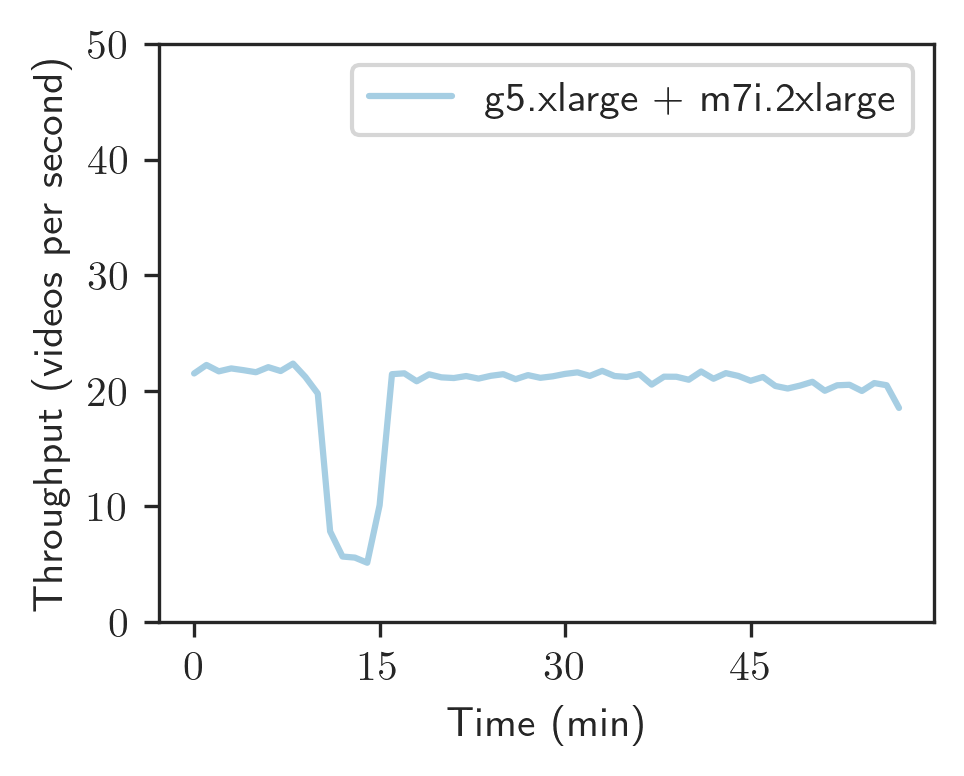

In [ ]:
FIGRATIO = 3 / 4
FIGWIDTH = 3.335  # inches
FIGHEIGHT = FIGWIDTH * FIGRATIO
FIGSIZE = (FIGWIDTH, FIGHEIGHT)
BIG_SIZE = 10

COLORS = sns.color_palette("Paired")
sns.set_style("ticks")
sns.set_palette(COLORS)

plt.rcParams.update(
    {
        "figure.figsize": FIGSIZE,
        "figure.dpi": 300,
        "text.usetex": True,
    }
)
plt.rc("font", size=BIG_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=BIG_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=BIG_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=BIG_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=BIG_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=BIG_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIG_SIZE)  # fontsize of the figure title

fig, ax = plt.subplots()

ax.plot(idx_s3_1_1_wf, values_s3_1_1_wf, label="g5.xlarge + m7i.2xlarge")

# ax.axhline(
#     y=inference_tput_mean, color="orange", linestyle="--", label="Max GPU throughput"
# )

plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(nbins=6))

plt.xlabel("Time (min)")
plt.ylabel("Throughput (videos per second)")
plt.ylim(0, 50)
plt.legend()
plt.savefig("worker-failures.pdf", bbox_inches='tight')